In [1]:
# Importing the necessary libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
import glob
import datetime
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_val_predict

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 400)

In [3]:
df = pd.read_pickle("./Data/dataframefull.pickle")
df_art = pd.read_pickle("./Data/articles.pickle")

In [4]:
df.head()

,visit_id,user_id,visit_number,date,day_of_week,article_name,article_id,price,quantity,total_price,shop_cart_value,shop_cart_item_count,shop_cart_unique_articles,country,region,city,city_id,women_article,men_article,kids_article,homeandliving_article,campaign_involved,category,category_slim,brand,product_line,product_group,genre_column_placeholder,device_category,device_browser,device_os,stock_value,year_month,min_purchase_date,user_type
0,551960553811,553811,1,2018-09-10,0,Geschenkgutschein 10 EUR,200000000010,10.0,1,10.0,30.0,2,2,Germany,Lower Saxony,Brunswick,1004478,0,1,0,0,False,Herren,men,(not set),Herren,Herren,Geschenkgutschein 10 EUR/Herren/Herren/Herren,desktop,Firefox,Windows,5.77,201809,201809,first
1,551960553811,553811,1,2018-09-10,0,Geschenkgutschein 20 EUR,200000000020,20.0,1,20.0,30.0,2,2,Germany,Lower Saxony,Brunswick,1004478,0,1,0,0,False,Herren,men,(not set),Herren,Herren,Geschenkgutschein 20 EUR/Herren/Herren/Herren,desktop,Firefox,Windows,5.77,201809,201809,first
2,242735254033,254033,1,2018-01-04,3,Geschenkgutschein 10 EUR,200000000010,10.0,1,10.0,80.0,3,3,Germany,Lower Saxony,Wunstorf,9048892,1,1,0,0,True,Damen/Geschenkgutscheine,women/men,(not set),Herren,Herren,Geschenkgutschein 10 EUR/Damen/Geschenkgutsche...,desktop,Firefox,Windows,11.40,201801,201801,first
3,242735254033,254033,1,2018-01-04,3,Geschenkgutschein 20 EUR,200000000020,20.0,1,20.0,80.0,3,3,Germany,Lower Saxony,Wunstorf,9048892,1,1,0,0,True,Damen/Geschenkgutscheine,women/men,(not set),Herren,Herren,Geschenkgutschein 20 EUR/Damen/Geschenkgutsche...,desktop,Firefox,Windows,11.40,201801,201801,first
4,242735254033,254033,1,2018-01-04,3,Geschenkgutschein 50 EUR,200000000050,50.0,1,50.0,80.0,3,3,Germany,Lower Saxony,Wunstorf,9048892,1,1,0,0,True,Damen/Geschenkgutscheine,women/men,(not set),Herren,Herren,Geschenkgutschein 50 EUR/Damen/Geschenkgutsche...,desktop,Firefox,Windows,11.40,201801,201801,first


In [48]:
df_art.head()

,visit_id,date,article_id,article_name,price,women_article,men_article,kids_article,homeandliving_article,category_slim,brand
226,570727363200,2017-11-19,200000000010,Geschenkgutschein 10 EUR,10.0,0,1,0,0,men,(not set)
29,135611602309,2017-11-22,200000000010,Geschenkgutschein 10 EUR,10.0,0,1,0,0,men,(not set)
174,199278169302,2017-11-25,200000000010,Geschenkgutschein 10 EUR,10.0,0,1,0,0,men,(not set)
83,253024190019,2017-12-04,200000000010,Geschenkgutschein 10 EUR,10.0,0,1,0,0,men,(not set)
115,482743120185,2017-12-11,200000000010,Geschenkgutschein 10 EUR,10.0,1,1,0,0,women/men,(not set)


## extra dataframes for plotting

In [29]:
#TD

Dataframe for the total revenue at a given date and the total quantity at a given date

In [7]:
summation = df.groupby(["date"]).sum()
df_sum = pd.DataFrame(summation,columns=["total_price"])
df_sum.reset_index(level=0,inplace=True)
df_quant = pd.DataFrame(summation,columns=["quantity"])
df_quant.reset_index(level=0,inplace=True)

Scale total revenue and quantity to put them both into a plot and make them compareable

In [31]:
std_scaler = preprocessing.StandardScaler()
sum_scale = df_sum.copy()
quant_scale = df_quant.copy()
sum_scale["total_price"] = std_scaler.fit_transform(df_sum[["total_price"]])
quant_scale["quantity"] = std_scaler.fit_transform(df_quant[["quantity"]])

In [32]:
#give quant_scale a feature with zeroes to easier plot a null line later
quant_scale["null"] = 0

In [33]:
#TD
#dataframe for plotting the shopping cart value over time
df_plot_time_to_cartvalue = df.drop_duplicates(subset ="visit_id")

# Plots

## revenue and quantity per date (unscaled)

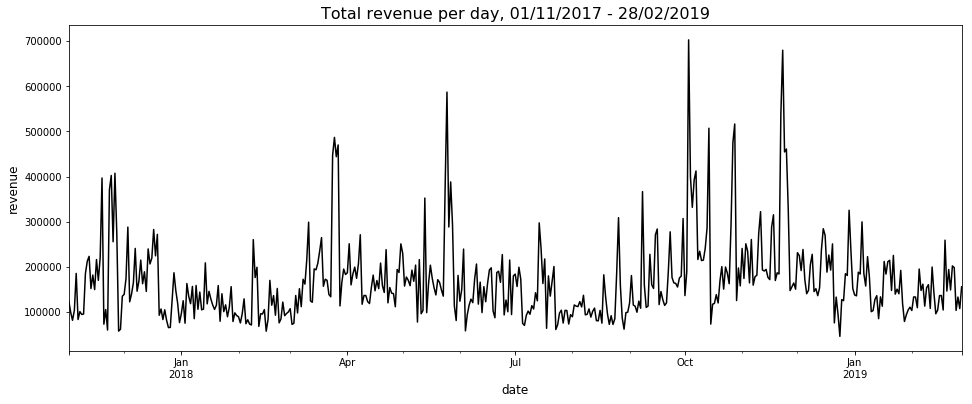

In [34]:
plt.figure(figsize=(16,6))
df_sum.set_index('date').total_price.plot(color='black')
plt.xlim('2017-11-01', '2019-02-28')
plt.xlabel('date', fontsize=12)
plt.ylabel('revenue', fontsize=12)
plt.title('Total revenue per day, 01/11/2017 - 28/02/2019', fontsize=16)
plt.show()

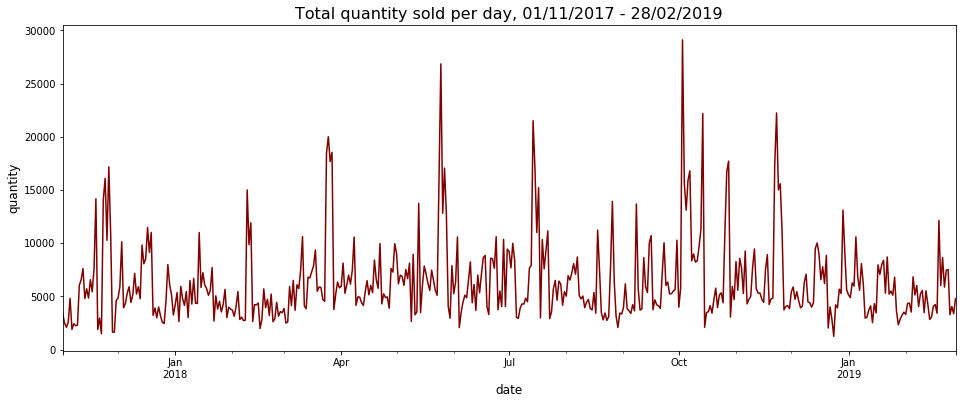

In [35]:
plt.figure(figsize=(16,6))
df_quant.set_index('date').quantity.plot(color='maroon')
plt.xlim('2017-11-01', '2019-02-28')
plt.xlabel('date', fontsize=12)
plt.ylabel('quantity', fontsize=12)
plt.title('Total quantity sold per day, 01/11/2017 - 28/02/2019', fontsize=16)
plt.show()

## total revenue and quantity per date (scaled)

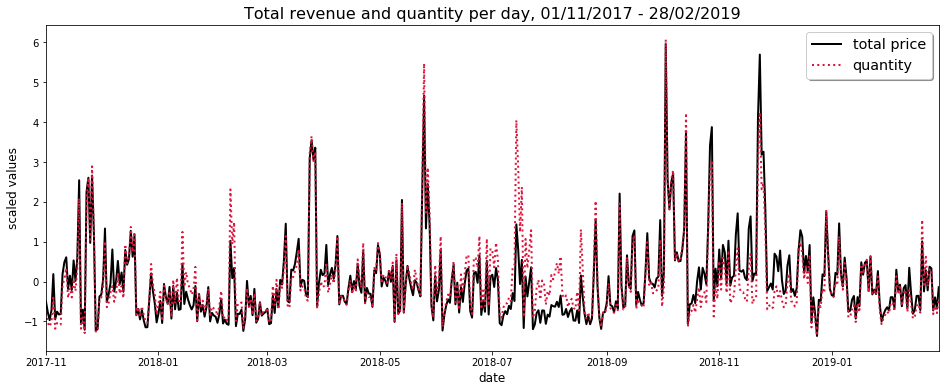

In [36]:
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(sum_scale["date"], sum_scale["total_price"], 'k-', label='total price', linewidth=2)
ax.plot(quant_scale["date"], quant_scale["quantity"], color="crimson" ,linestyle=':', label='quantity', linewidth=2)

plt.xlim('2017-11-01', '2019-02-28')

plt.xlabel('date', fontsize=12)
plt.ylabel('scaled values', fontsize=12)
plt.title('Total revenue and quantity per day, 01/11/2017 - 28/02/2019', fontsize=16)

legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')

# background color on the legend
legend.get_frame().set_facecolor('w')

plt.show()

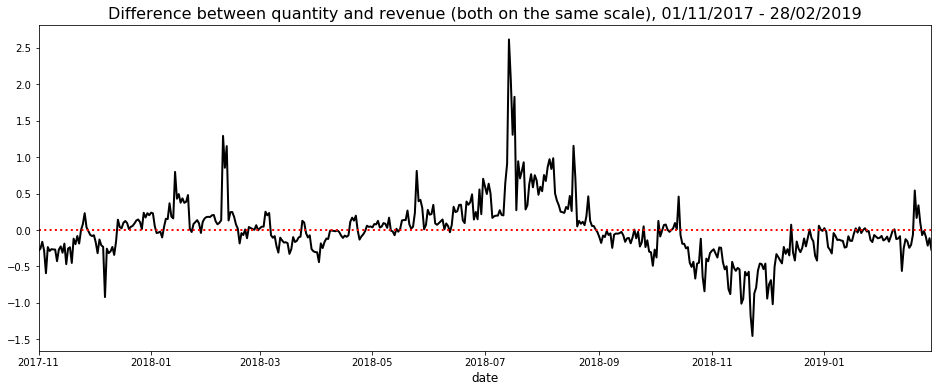

In [37]:
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(sum_scale["date"], (quant_scale.set_index('date').quantity - sum_scale.set_index('date').total_price), color='black', linestyle='-', linewidth=2, label="difference between quantity and price")
ax.plot(quant_scale["date"], quant_scale.set_index('date').null, color='red', linestyle=':', linewidth=2)

plt.xlim('2017-11-01', '2019-02-28')

plt.xlabel('date', fontsize=12)
plt.title('Difference between quantity and revenue (both on the same scale), 01/11/2017 - 28/02/2019', fontsize=16)
plt.show()

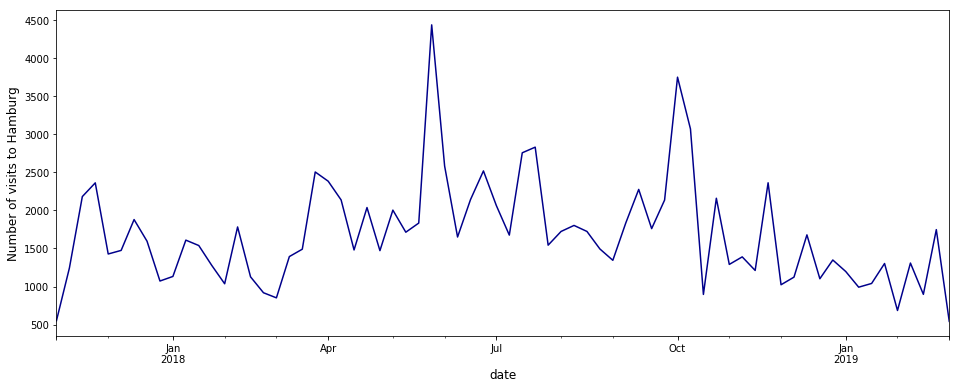

In [38]:
#testplot for hamburg
plt.figure(figsize=(16,6))
df[df['city'] == 'Hamburg'].set_index('date').visit_number.resample('W').count().plot(color='darkblue')
plt.xlim('2017-11-01', '2019-02-28')
plt.xlabel('date', fontsize=12)
plt.ylabel('Number of visits to Hamburg', fontsize=12)
#plt.title('Number of successful funded projects (per week), 04/2009 - 03/2019', fontsize=16)
plt.show()

//anaconda3/envs/nf2/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


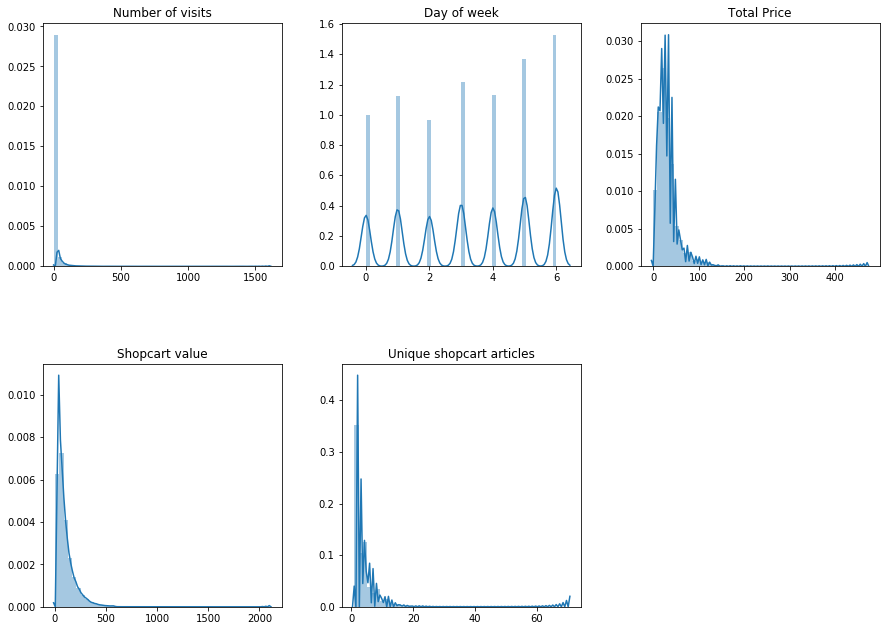

In [40]:
fig, ax = plt.subplots(2,3,figsize=(15,17))
plt.subplots_adjust(hspace=0.4, wspace=0.25)

# visits
plt.subplot(331)
sns.distplot(df.visit_number)
plt.title('Number of visits')
plt.xlabel('');

# day of week
plt.subplot(332)
sns.distplot(df.drop_duplicates(subset ="visit_id").day_of_week)
plt.title('Day of week')
plt.xlabel('');

# Total Price
plt.subplot(333)
sns.distplot(df.drop_duplicates(subset ="visit_id").total_price)
plt.title('Total Price')
plt.xlabel('');

# Shopping cart value
plt.subplot(334)
sns.distplot(df.drop_duplicates(subset ="visit_id").shop_cart_value)
plt.title('Shopcart value')
plt.xlabel('');

# Unique articles is cart
plt.subplot(335)
sns.distplot(df.drop_duplicates(subset ="visit_id").shop_cart_unique_articles)
plt.title('Unique shopcart articles')
plt.xlabel('');

plt.subplot(336)
plt.axis('off');



## Article lifecycle plot function

In [6]:
#drop samples where vouchers were used to reduce price to 0 as they would place heavy outliers not saying anything
df_art_nnull = df_art[df_art["price"]!=0]

In [7]:
df_art_nnull.reset_index();

In [59]:
#nicer plot with seaborn below , hence commented out
'''def lc_plot(article_id):
    fig, ax = plt.subplots(figsize=(16,6))
    ax.plot(df_art_nnull[df_art_nnull["article_id"]==article_id]["date"]\
            , df_art_nnull[df_art_nnull["article_id"]==article_id]["price"], 'k-', label='price', linewidth=2)
    plt.xlim(df_art_nnull[df_art_nnull["article_id"]==article_id]["date"].min()\
             , df_art_nnull[df_art_nnull["article_id"]==article_id]["date"].max())

    plt.xlabel('date', fontsize=12)
    plt.ylabel('price', fontsize=12)
    plt.title('Lifecylce of article {} (ID : {}), {} - {}'.format(df_art_nnull[df_art_nnull["article_id"]==article_id]["article_name"].min()\
                                                        , article_id\
                                                        , df_art_nnull[df_art_nnull["article_id"]==article_id]["date"].min()\
                                                        , df_art_nnull[df_art_nnull["article_id"]==article_id]["date"].max())\
              , fontsize=16)

    #legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')

    # background color on the legend
    #legend.get_frame().set_facecolor('w')

    plt.show()'''

#### Function to plot a single article:

In [8]:
def lc_plot(article_id):

    g = sns.relplot(x="date", y="price", kind="line", data=df_art_nnull[df_art_nnull["article_id"]==4062105526669], height=5, aspect=2)
    g.fig.autofmt_xdate()
    maxdate = df_art_nnull[df_art_nnull["article_id"]==article_id]["date"].max()
    mindate = df_art_nnull[df_art_nnull["article_id"]==article_id]["date"].min()
    plt.title('Lifecylce of article {} (ID : {}), {} - {}'.format(df_art_nnull[df_art_nnull["article_id"]==article_id]["article_name"].max()\
                                                        , article_id\
                                                        , mindate.strftime("%m/%d/%Y")\
                                                        , maxdate.strftime("%m/%d/%Y"))\
              , fontsize=14)
    plt.show()

In [93]:
df_art_nnull.sample(n=5)

,visit_id,date,article_id,article_name,price,women_article,men_article,kids_article,homeandliving_article,category_slim,brand
1975924,62136079830,2018-12-10,4062105674094,Offen geschnittener Blazer,41.66,1,0,0,0,women,TT_Denim
2377080,437828586579,2018-05-27,4060586752850,Relaxed Shorts,26.89,1,0,0,0,women,(not set)
2297288,667558520879,2018-11-09,4060586220861,Carrie Slim Jeans,43.33,1,0,0,0,women,TT_Casual
1672144,669993561480,2018-12-18,4059953234181,Langarmshirt mit Schrift-Artwork,4.33,0,0,1,0,kids,TT_Casual
1214727,702404388444,2017-11-15,4059491512826,Bandana mit Dachs-Motiv,4.19,0,0,1,0,kids,(not set)


//anaconda3/envs/nf2/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


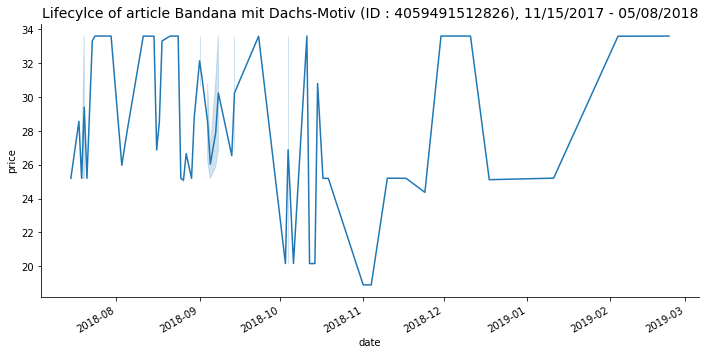

In [95]:
lc_plot(4059491512826)

#### Function to plot a sample of given, even, size

In [11]:
def samplot(size):
    '''Takes the size of the sample to be plotted. For ease of use please only use even numbers'''
    if size % 2 != 0:
        print("Error: Please use an even sample size.")
    else:
        fig, axes = plt.subplots(math.ceil(size/2),2, figsize=(17,17), sharex=True)
        fig.autofmt_xdate()
        pltdata = df_art_nnull.sample(n=size)
        artlist = pltdata["article_id"].tolist()
        for i, ax in enumerate(axes.flat):
            sns.relplot(x="date", y="price", kind="line", data=df_art_nnull[df_art_nnull["article_id"]==artlist[i]], ax=ax)
            ax.set_title('{}'.format(pltdata[pltdata["article_id"]==artlist[i]]["article_name"].min()))

        for i in range(1, len(artlist)+1):
            plt.close(i+1)

//anaconda3/envs/nf2/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


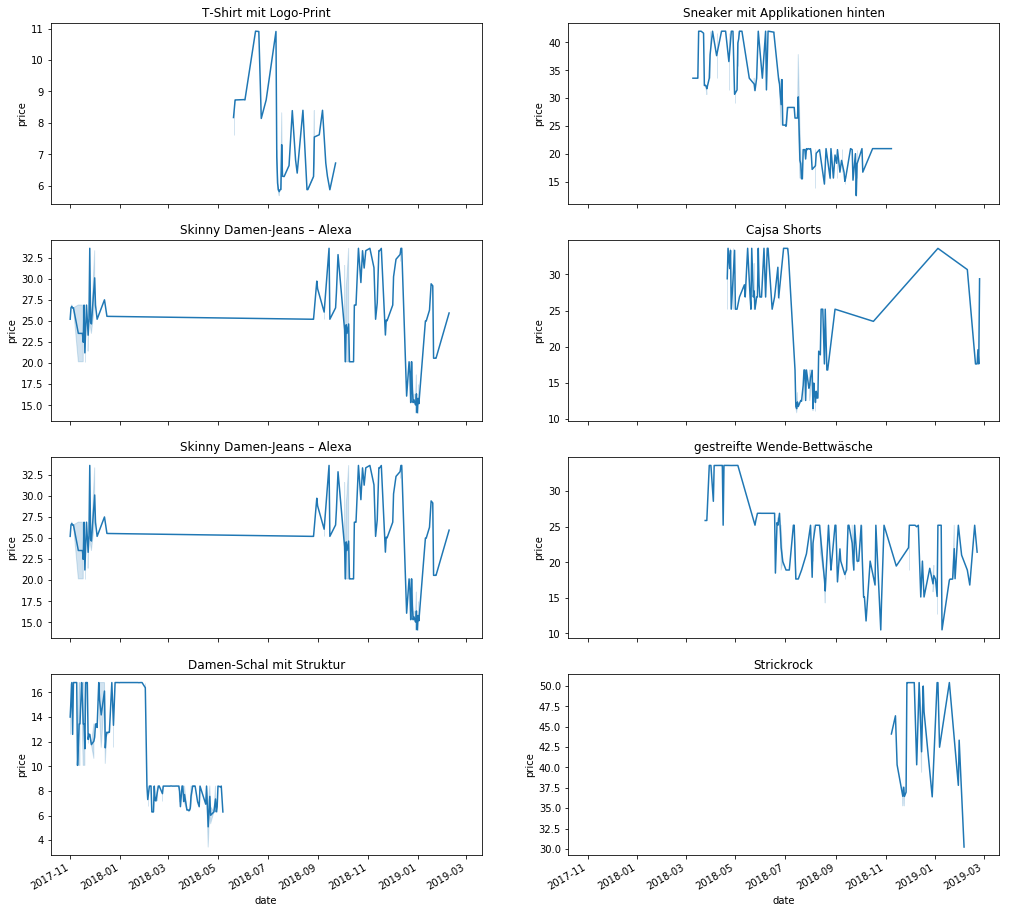

In [12]:
samplot(8)

In [ ]:
#TD check maybe like all skinny jeans ( regex)